# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Quantile regression with LightGBM

**Reference:** http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html<br>

<br></font>
</div>

# Import modules

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- In the following section, we generate a sinoide function + random gaussian noise, with 80% of the data points being our training samples (blue points) and the rest being our test samples (red points). 
- Generating a 1 dimension fake data allows us to easily visualize it and gain intuition on what sort of black magic our algorithm is doing.

<br></font>
</div>

In [29]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)


def gen_data(low, high, n_samples, scale=4, test_size=0.2, random_state=3):
    """generate training and testing data from the ground truth function"""
    np.random.seed(15)
    X = np.random.uniform(low, high, size=n_samples)

    # generate the response from the ground truth function and add
    # some random noise to it, scale controls the variance of the noise.
    y = ground_truth(X) + np.random.normal(scale=scale, size=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test


def plot_data(x_plot, X_train, X_test, y_train, y_test, low, high):
    """plot training and testing data"""
    s = 15
    plt.plot(x_plot, ground_truth(x_plot), "k-", alpha=0.5, lw = 3, label = 'ground truth')
    plt.scatter(X_train, y_train, s=s, alpha=0.2)
    plt.scatter(X_test, y_test, s=s, alpha=0.2, color='red')
    plt.xlim((low, high))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.show()

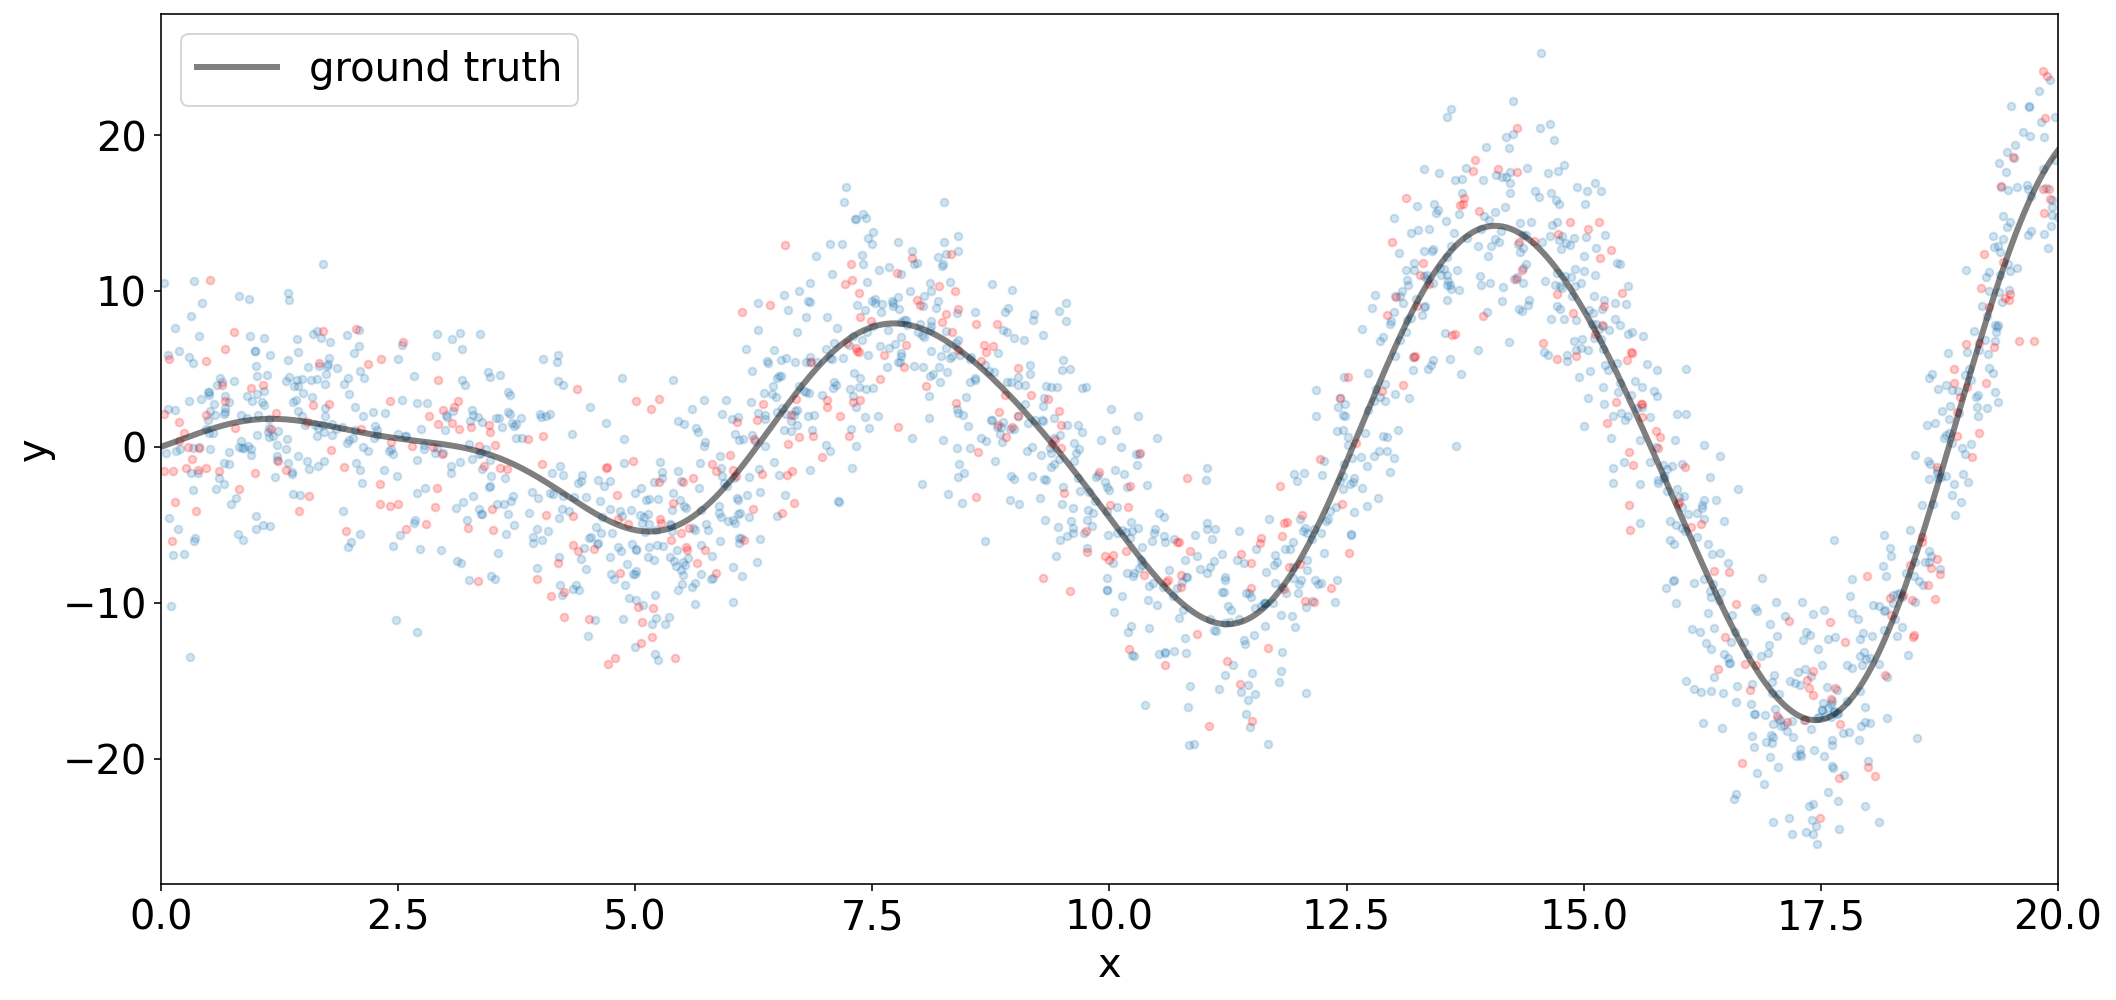

In [30]:
low = 0
high = 20
x_plot = np.linspace(low, high, 500)

n_samples = 2000
X_train, X_test, y_train, y_test = gen_data(low=low, high=high, n_samples=n_samples)
plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

# Model for the mean

<div class="alert alert-block alert-info">
<font color=black><br>

- We first use the squared error loss as our objective function to train our tree model and visualize the predicted value versus the ground truth.
- Essentially we are getting a baseline model for the mean.

<br></font>
</div>

In [32]:
lgb_params = {
    'n_jobs': 1,
    'max_depth': 4,
    'min_data_in_leaf': 10,
    'subsample': 0.9,
    'n_estimators': 80,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt'
}
lgb_l2 = LGBMRegressor(objective='regression', **lgb_params)
lgb_l2.fit(X_train[:, np.newaxis], y_train);

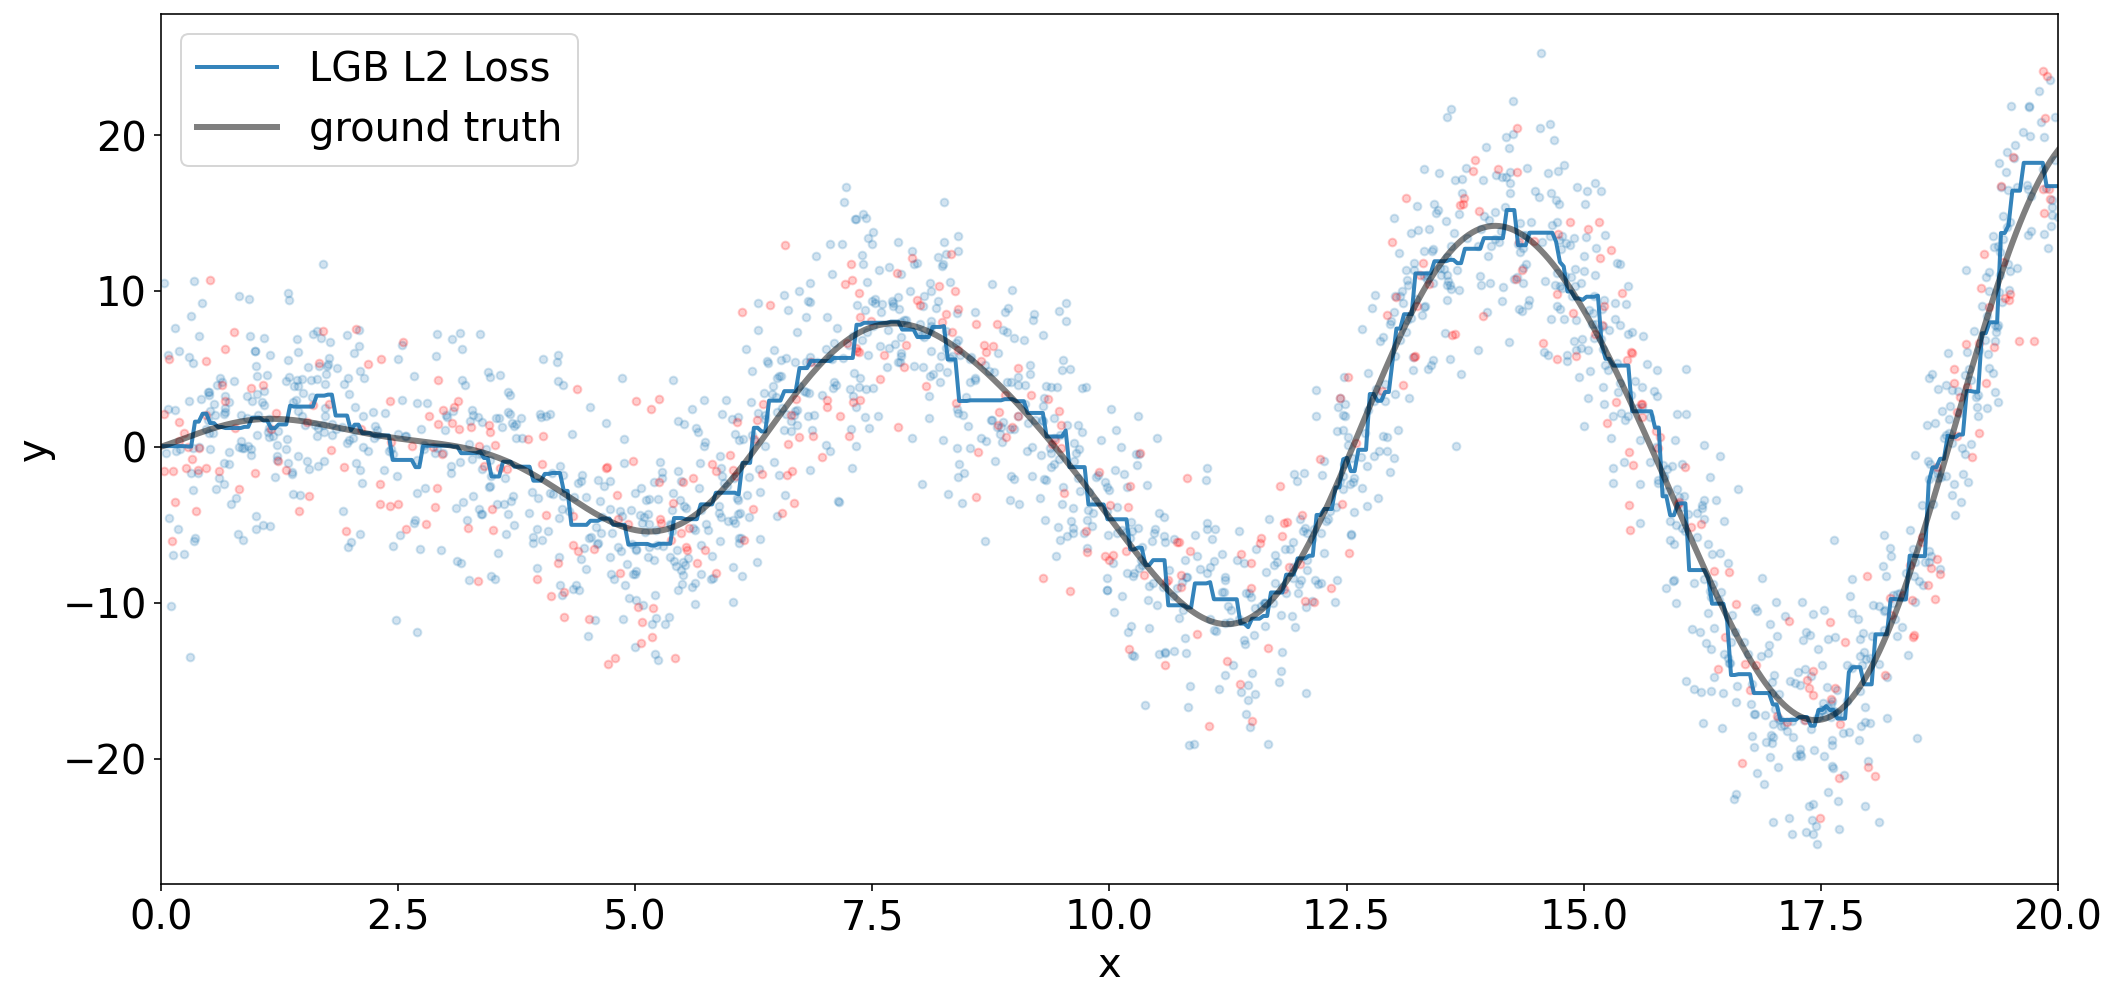

In [33]:
plt.plot(x_plot, lgb_l2.predict(x_plot[:, np.newaxis]),
         label='LGB L2 Loss', alpha=0.9, linewidth=2)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

# Model for the lower & uuper percentiles

<div class="alert alert-block alert-info">
<font color=black><br>

- The next step is to use a different objective function: **quantile**
- We'll use it twice: one for the lower and the other for the upper.
- The 0.5, hence the median is there just to try it; we generally do not want to use.

<br></font>
</div>

In [35]:
quantile_alphas = [0.1, 0.5, 0.9]

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile',
                        alpha=quantile_alpha, **lgb_params)
    lgb.fit(X_train[:, np.newaxis], y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

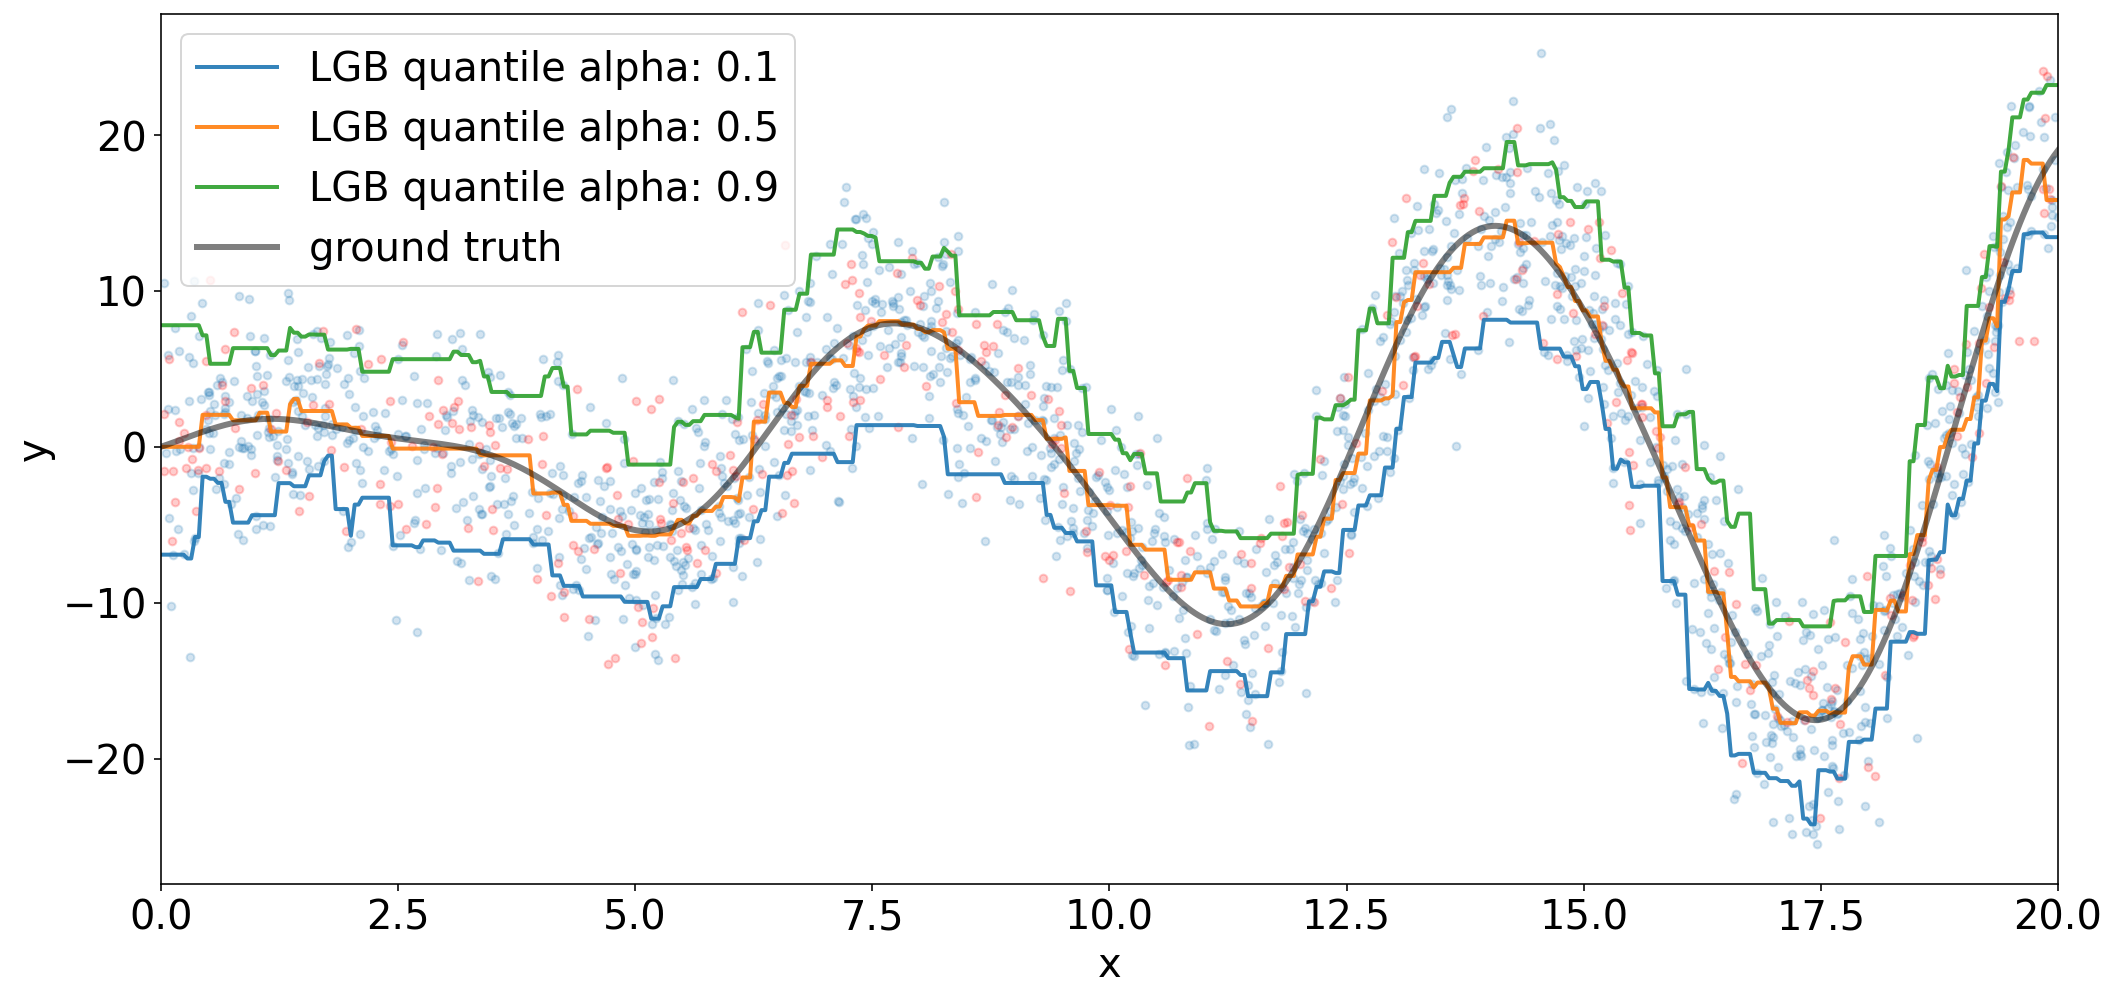

In [36]:
for quantile_alpha, lgb in lgb_quantile_alphas.items():
    plt.plot(x_plot, lgb.predict(x_plot[:, np.newaxis]),
             label='LGB quantile alpha: {}'.format(quantile_alpha),
             alpha=0.9, linewidth=2)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

# Creating manually the quantile loss function

In [48]:
def compute_quantile_loss(y_true, y_pred, quantile):
    """    
    Parameters
    ----------
    y_true : 1d ndarray
        Target value.

    y_pred : 1d ndarray
        Predicted value.

    quantile : float, 0. ~ 1.
        Quantile to be evaluated, e.g., 0.5 for median.
    """

    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)

In [49]:
# Suppose we've made a prediction for a single point with a true value of zero,
# and our predictions range from -1 to +1 that is, our errors also range from -1 to +1.
n_samples = 1000
y_true = np.zeros(n_samples)
y_pred = np.linspace(-1, 1, n_samples)

quantiles = [0.1, 0.5, 0.9]
quantile_losses = [
    compute_quantile_loss(y_true, y_pred, quantile)
    for quantile in quantiles
]

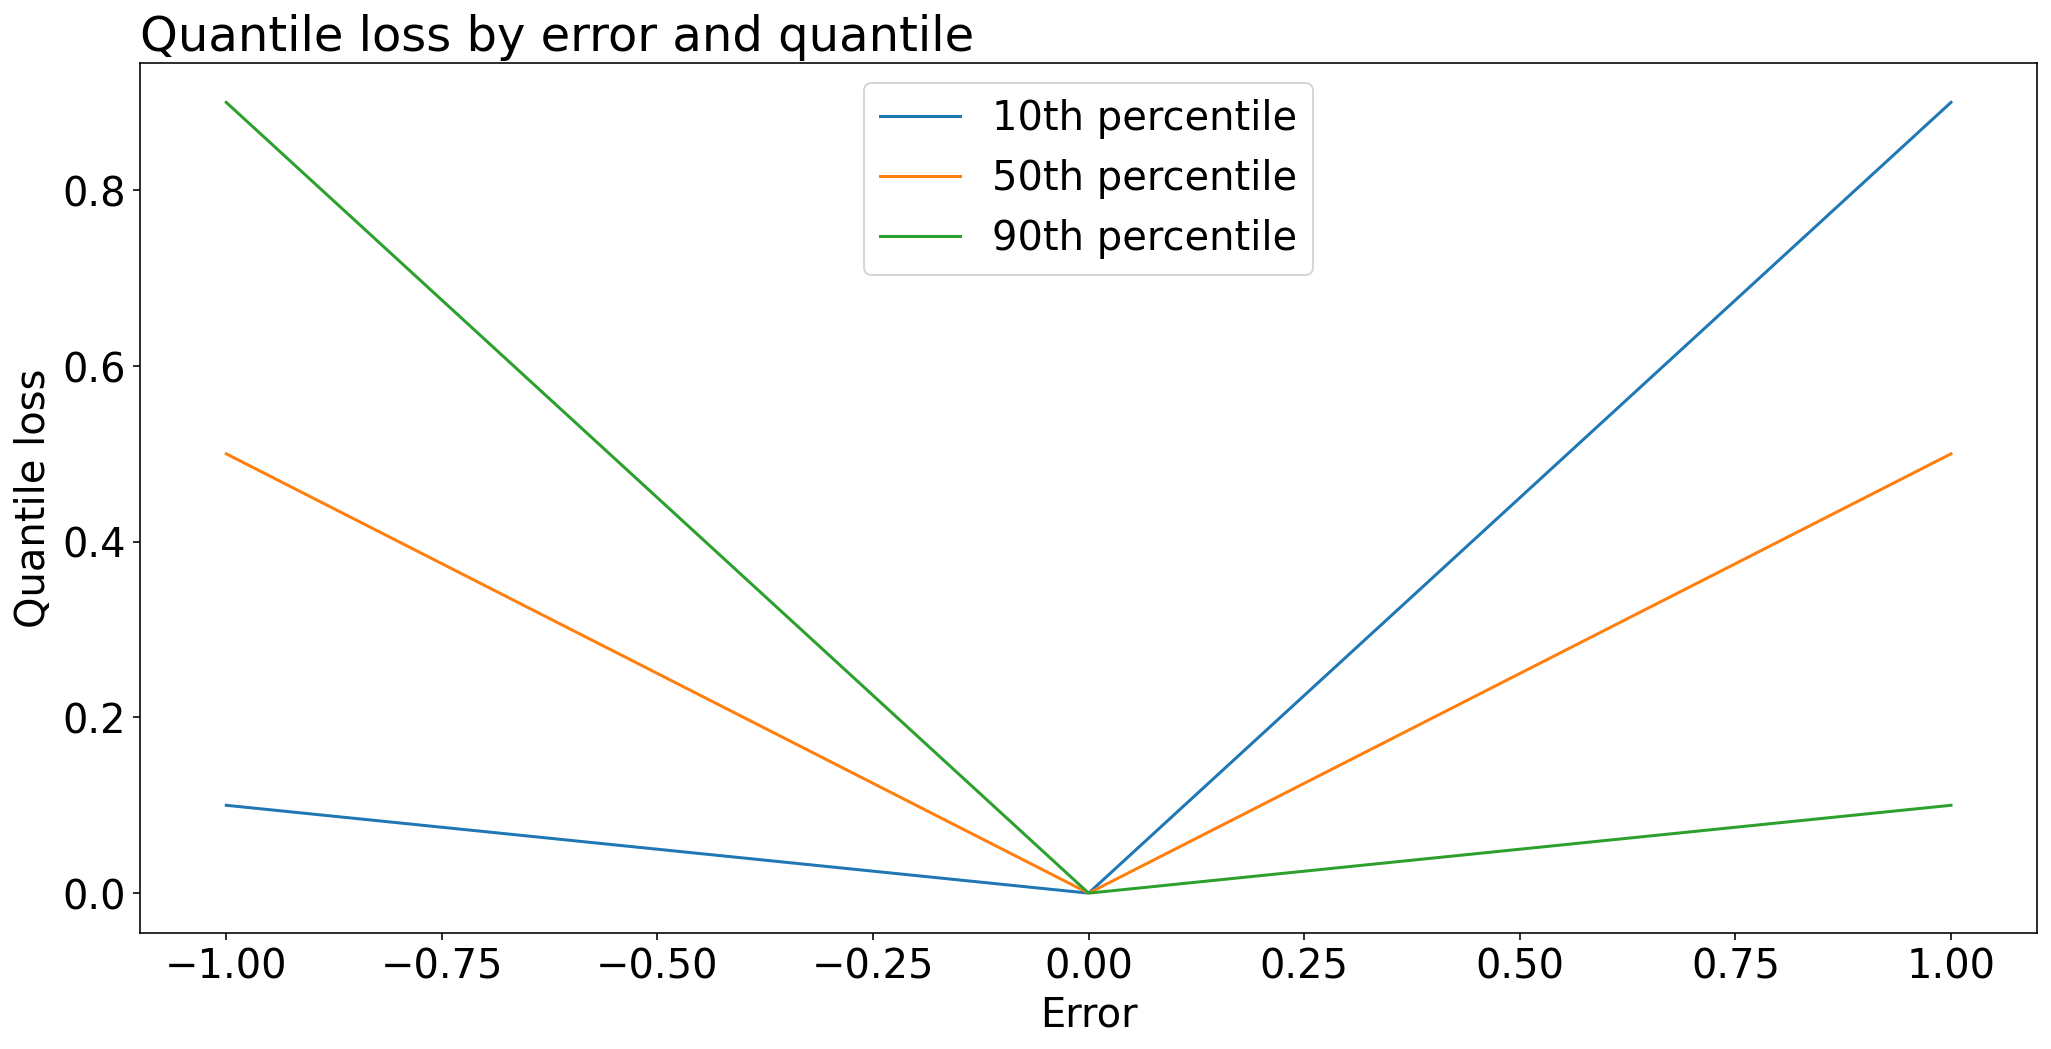

In [50]:
for quantile_loss in quantile_losses:
    plt.plot(y_pred, quantile_loss)

plt.legend([str(int(q * 100)) + 'th percentile' for q in quantiles])
plt.xlabel('Error')
plt.ylabel('Quantile loss')
plt.title('Quantile loss by error and quantile', loc='left')
plt.show()

# Evaluatiing the percentiles

<div class="alert alert-block alert-info">
<font color=black><br>

- Like all other machine learning tasks, we can check how our model performed by looking at some evaluation metrics. 
- Since our quantile loss differs depending on the quantile we've specified. 
- Hence, we'll look at the quantile loss at different levels for each of our model.
- The bar plot needs to be read like that: 1) for each model we calculate the loss by passing 3 different alphas, 2) the model shows that we have done all Ok because the lowest values is in the diagonal meaning model lgb_90 has lowest loss when we pass 0.9, 3) this makes sense as the quantile loss penalises values asymetrically.
- **To conclude**: model that were specified to optimized for quantile 10%/50%/90% performed better on quantile 10%/50%/90% loss respectively.
    

<br></font>
</div>

In [53]:
def create_loss_comparision():
    model_name = []
    columns = []
    results = []

    y_true = ground_truth(x_plot[:, np.newaxis])
    for quantile_alpha, lgb in lgb_quantile_alphas.items():
        quantile_str = str(int(quantile_alpha * 100))
        columns.append('quantile_' + quantile_str)
        model_name.append('lgb_' + quantile_str)

        y_pred = lgb.predict(x_plot[:, np.newaxis])
        result = [
            compute_quantile_loss(y_true, y_pred, quantile).mean()
            for quantile in quantile_alphas
        ]
        results.append(result)


    df_results = pd.DataFrame(results, columns=columns)
    df_results['model'] = model_name
    return df_results

In [54]:
df_results = create_loss_comparision()
df_results

,quantile_10,quantile_50,quantile_90,model
0,2.928753,4.993926,7.059099,lgb_10
1,4.525631,4.508694,4.491757,lgb_50
2,7.186226,5.021055,2.855885,lgb_90


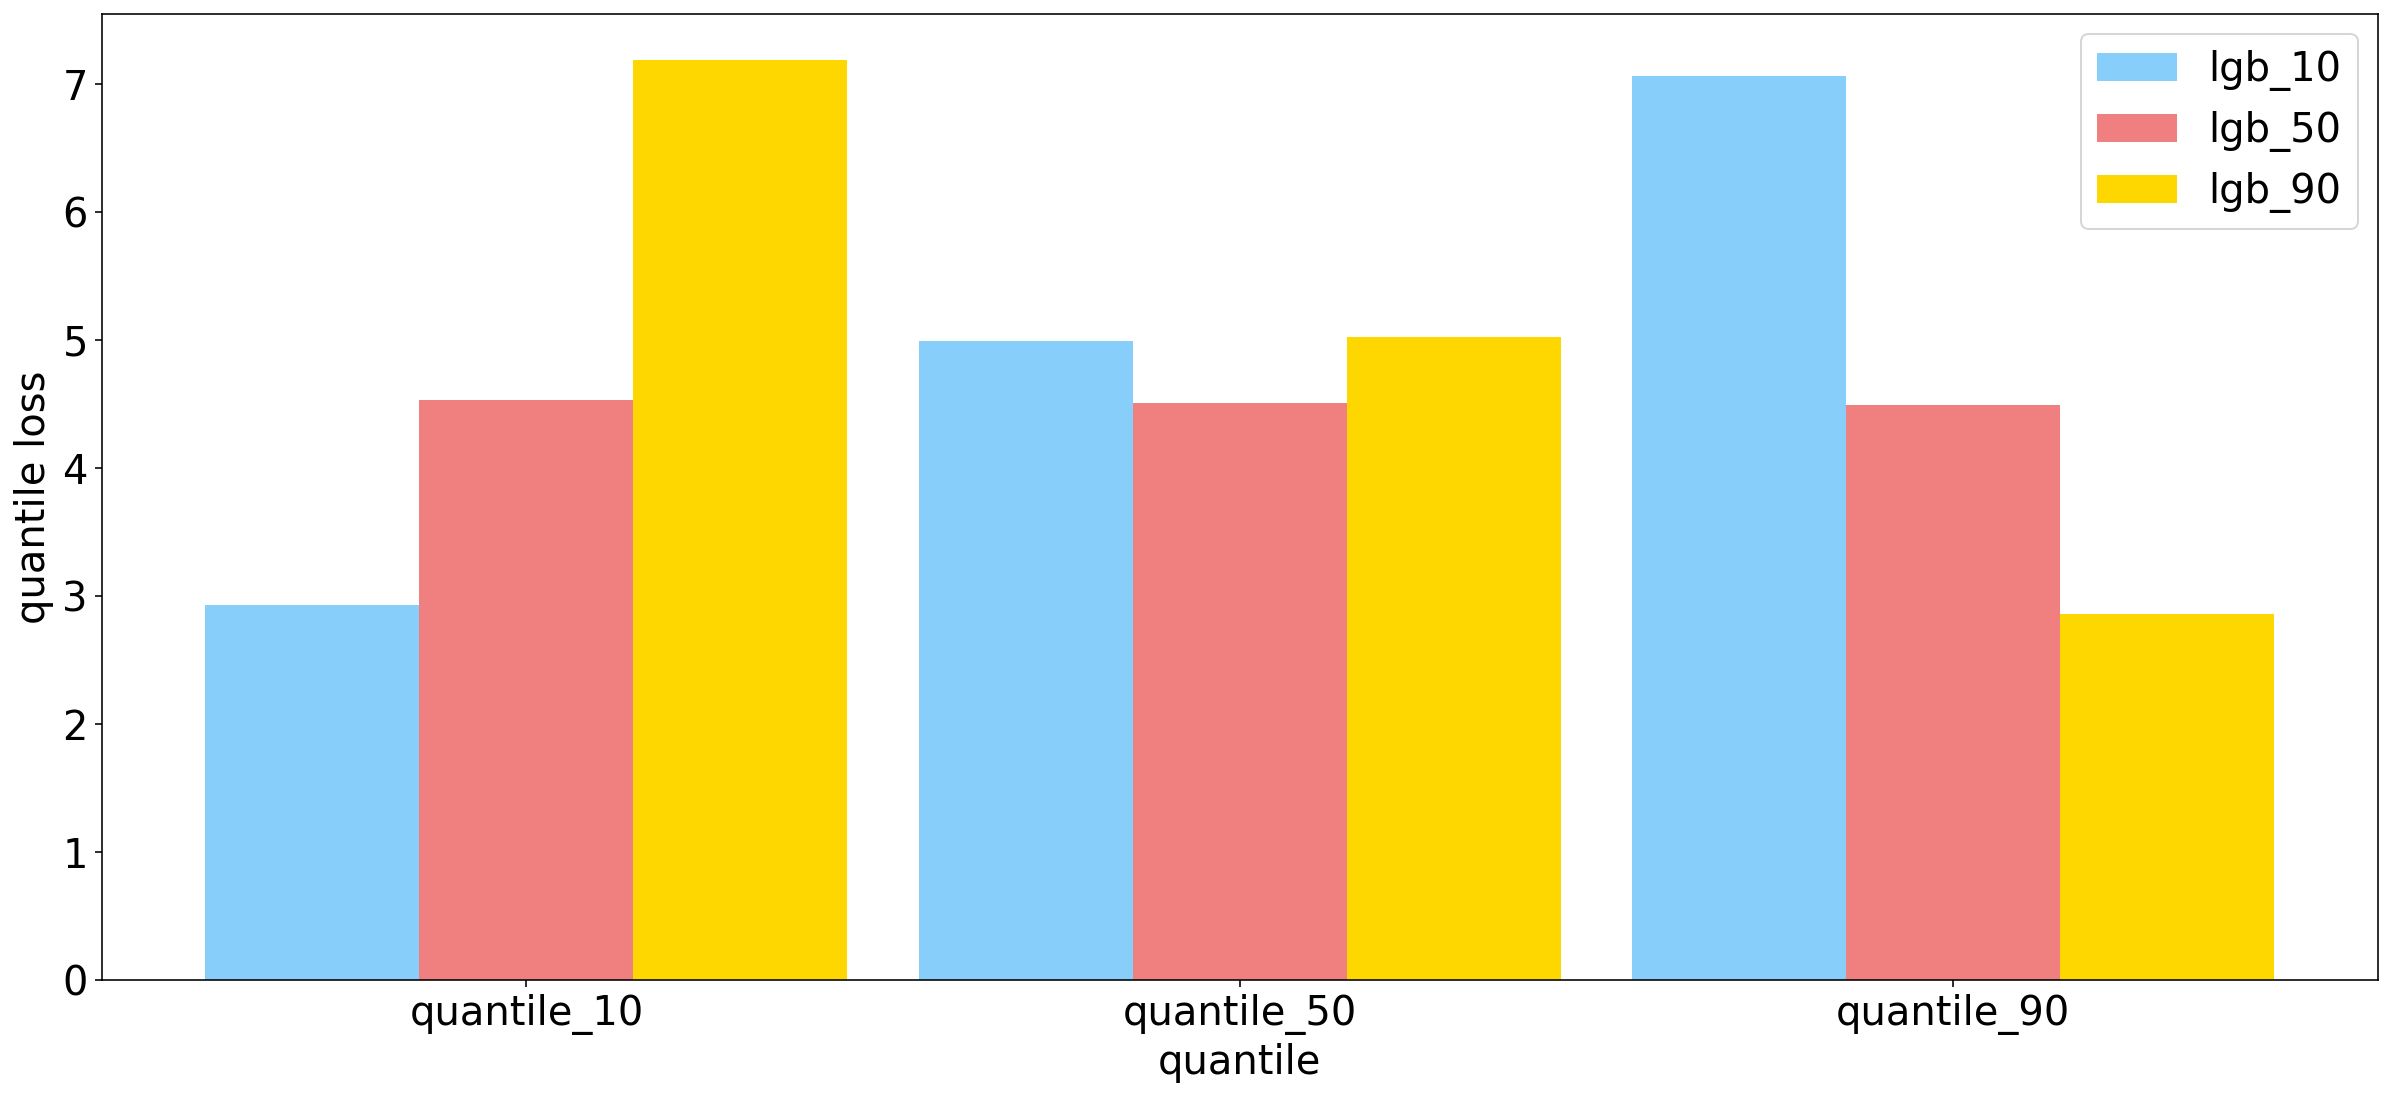

In [57]:
def score_barplot(df_results, model_col='model'):
    metrics_cols = ['quantile_10', 'quantile_50', 'quantile_90']
    colors = ['lightskyblue', 'lightcoral', 'gold']

    width = 0.3
    ind = np.arange(len(metrics_cols))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    n_rows = df_results.shape[0]
    for i in range(n_rows):
        x = ind + (i * width)
        height = df_results.loc[i, metrics_cols]
        label = df_results.loc[i, model_col]
        ax.bar(x, height, width, label=label, color=colors[i])

    half_width = (n_rows // 2) * width
    ax.set_xticks(ind + half_width)
    ax.set_xticklabels(metrics_cols)
    ax.set_ylabel('quantile loss')
    ax.set_xlabel('quantile')
    ax.legend()
    plt.tight_layout()
    plt.show()
    

score_barplot(df_results)

# Conclusions

<div class="alert alert-block alert-danger">
<font color=black><br>

- Scikit learn has a built-in quantile objetive function. The same is true for LightGBM
- XGBoost does not have one, so you have to code it yourself.
- Please remember that you need to do some trickery to use the quantile loss, as the its gradient has a discontinuity and the Hessian is zero.
- In fact we talk about hard and soft quantile loss function.

<br></font>
</div>